In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import helper_methods
import yfinance

In [14]:
# TO DO: In a different file, find two cointegrated stocks. Those two stocks will replace KO and PEP

# Pt 1 of this file visualizes the cointegration of the 2 stocks. Pt 2 of this file researches buy as sell signals


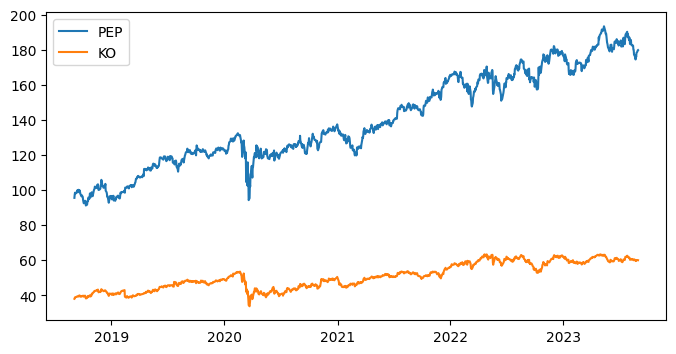

In [15]:

# Pt 1: Begin Visualizing cointegration

# Plot the two assets
df_1 = helper_methods.get_stock_prices("PEP", "2018-09-01", "2023-08-31")
df_2 = helper_methods.get_stock_prices("KO", "2018-09-01", "2023-08-31")
stock_1 = df_1['Close']
stock_2 = df_2['Close']

# Note: need to change the labels
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(stock_1, label = 'PEP')
ax.plot(stock_2, label = 'KO')
ax.legend()
plt.show()

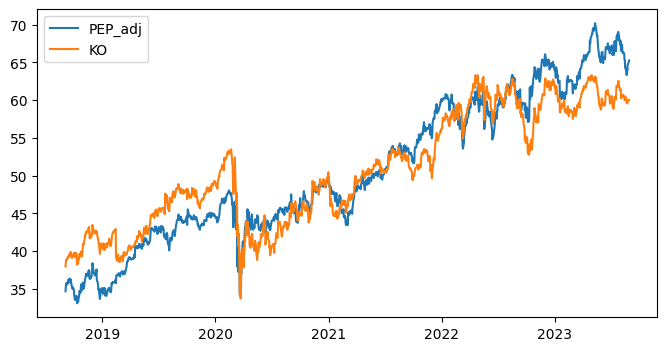

In [16]:
# We can see that PEP and KO roughly move together, but to see this better, let's normalize them to see them right next to each other
stock_1_adjusted = stock_1 / (np.mean(stock_1) / np.mean(stock_2))

# Note: need to change labels
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(stock_1_adjusted, label = 'PEP_adj')
ax.plot(stock_2, label = 'KO')
ax.legend()
plt.show()

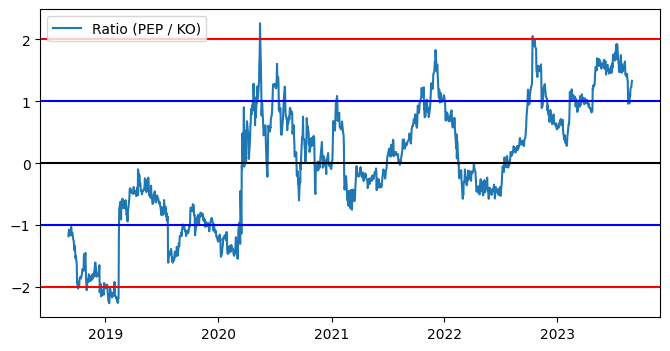

In [55]:
# Use ratios to calculate spread
ratio = stock_1 / stock_2

# Normalize the series
z_score = (ratio - ratio.mean()) / ratio.std()

# Note: need to change labels
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(z_score, label = 'Ratio (PEP / KO)')
plt.axhline(z_score.mean(), color = 'black')

# 68% of the data lies within 1 standard deviation
plt.axhline(1.0, color = 'blue')
plt.axhline(-1.0, color = 'blue')

# 95% of data lies within 2 standard deviations from mean
plt.axhline(2.0, color = 'red')
plt.axhline(-2.0, color = 'red')

ax.legend()
plt.show()


# This ratio appears stationary (not entirely, but if we find a better cointegrated pair it should appear more stationary)
# Note that this visualization does have look ahead bias. For example, the z score threshold in 2020 takes into account data from 2022.

In [56]:
# Pt 2: Begin signal research

# Split train and test data
train = ratio[0:round(.8*len(ratio))]
test = ratio[round(.8*len(ratio)):]

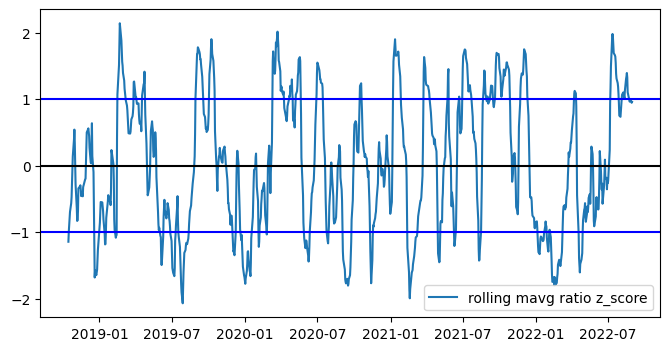

0.025332988303173522


In [60]:
# Adjust the graph to moving average to avoid look ahead bias (we might want to adjust the windows later)

# 1 day moving avg represents our current mean
mavg_5_day = train.rolling(window=5).mean()

# 30 day moving avg represents our historical mean
mavg_30_day = train.rolling(window=30).mean()
std_30_day = train.rolling(window=30).std()

# Calculate z-score for difference between current and historical mean
z_score_30vs5 = (mavg_5_day - mavg_30_day) / std_30_day

# Plot new graph based off moving avg
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(z_score_30vs5, label = 'rolling mavg ratio z_score')
plt.axhline(0, color = 'black')
plt.axhline(1.0, color = 'blue')
plt.axhline(-1.0, color = 'blue')
plt.legend()
plt.show()

# Note that this graph's signals don't look as powerful as the previous graph, but that is because we don't have look ahead bias here
# Also note that this data will not follow the 68/95/99 rule because we are comparing the current moving average to the standard deviation of a longer moving average.
# Ratios further from a mean still signal divergence, but just not at the exact percentages of 68/95/99




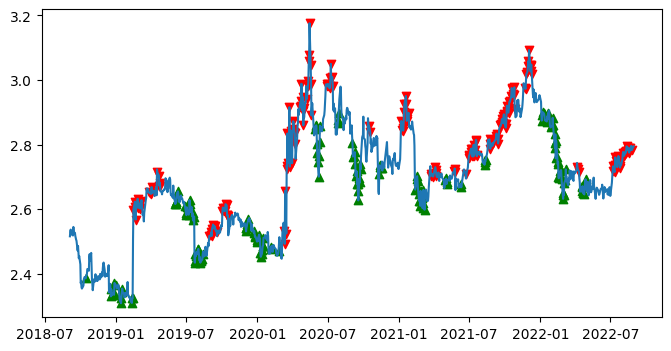

In [87]:
# With the graph above, we will want to trade the spread when the rolling moving average ratio moves outside the blue band.
# If the value is above the band, that means that stock_1 (PEP) is overvalued compared to stock_2 (KO), so we will sell the spread, which means short stock_1 and long stock_2
# If the value is below the band, that means that stock_1 (PEP) is undervalued compared to stock_2 (KO), so we will buy the spread, which means long stock_1 and short stock_2


trades = train.copy()
trades[z_score_30vs5 > 1] = -1 # when the z-score is above 1, sell the spread
trades[z_score_30vs5 < -1] = 1 # when the z-score is below -1, buy the spread
trades[(z_score_30vs5 >= -1) & (z_score_30vs5 <= 1) | np.isnan(z_score_30vs5)] = 0 # otherwise, do nothing

# TO DO: add a stop loss if this gets too far away from the mean. Maybe 3.5 SDs away?

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(train, label='z_score_30vs5')
ax.scatter(train.index[trades == 1], train[trades == 1], color='green', marker='^', label='Buy (1)')
ax.scatter(train.index[trades == -1], train[trades == -1], color='red', marker='v', label='Sell (-1)')
plt.show()


In [ ]:
# TO DO: make a function that calculates profit, add stop loss on test set
# Let's assume we can buy fractional shares, and we long / short $100 of each stock during each signal.